# INTRODUCTION

The main processes on an image are:
  
1. **Undistort:** camera calibration matrix and distortion coefficients (using chessboard)
2. **Binarize:** color thresholding, gradient thresholding, etc.
3. **Birdeye:** prespective transform -> applied to binary image
4. **Polynomial curve fitting:** sliding window, histogram
5. **Compare offset:** from the center of lane
6. **Draw surface:** enclosed between two lanes

**For the video:** it's the same thing for the most part. It's just that in video (sequence of frames/images) we can infer lane lines based on previous frames.

***
# CAMERA CALIBRATION AND UNDISTORT

**STEPS:**

1. Number of inside corners: `nx`, `ny`
2. Make a list of calibration images: `for fname in glob.glob(camera_cal/*.jpg)`, `img = cv2.imread(fname)`
3. Convert to grayscale: `gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`
4. Find the chessboard corners: `ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)`
5. If corners found (`if ret:`), draw and display corners: `cv2.drawChessboardCorners(img, (nx, ny), corners, ret)`, `plt.imshow(img)`
6. Having object points and image points, we can use `cv2.calibrateCamera()` for calibration. It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.
7. Having camera matrix and distortion parameters, we can **_undistort_** images using `cv2.undistort(img, mtx, dist, None, newcameramtx)`, where `newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))` and `h,  w = img.shape[:2]`. 
8. We can use the **_ROI_** to crop the image: `x,y,w,h = roi`, `dst = dst[y:y+h, x:x+w]` and `cv2.imwrite('calibresult.png',dst)`.

**NOTE:** camera calibration should be only done once. So, in videos, onces you calibrated the camera first time/frame just save it and for the next frames just load that calibration.

- [OpenCV source](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html)
- [Other sources-1](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)
- [Other sources-2](https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html)
- [Other sources-3](https://www.mathworks.com/help/vision/ug/camera-calibration.html)

**On `numpy.meshgrid` & `numpy.mgrid`:** Refer to [this page](http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

In [4]:
class Undistort:
    
    def __init__(self, nx, ny):
        self.nx = nx
        self.ny = ny
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        
    def calibrate(self, cal_img_pth):
        
        # 3D real world and image plance arrays
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        images = glob.glob('{}/*.jpg'.format(cal_img_pth))
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, 
                                                                               imgpoints, 
                                                                               gray.shape[::-1], 
                                                                               None, 
                                                                               None)
    def undistort(self, img_pth):
        return cv2.undistort(cv2.imread(img_pth), 
                             self.mtx, self.dist, 
                             newCameraMatrix=self.mtx)
    
    def show_undistorted(self, img_pth):
        fig, ax = plt.subplots(1, 2, figsize=(20,15))
        img = cv2.imread(img_pth)
        img_undistorted = self.undistort(img_pth)
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Distorted')
        ax[1].set_title('Undistorted')
        plt.show()      

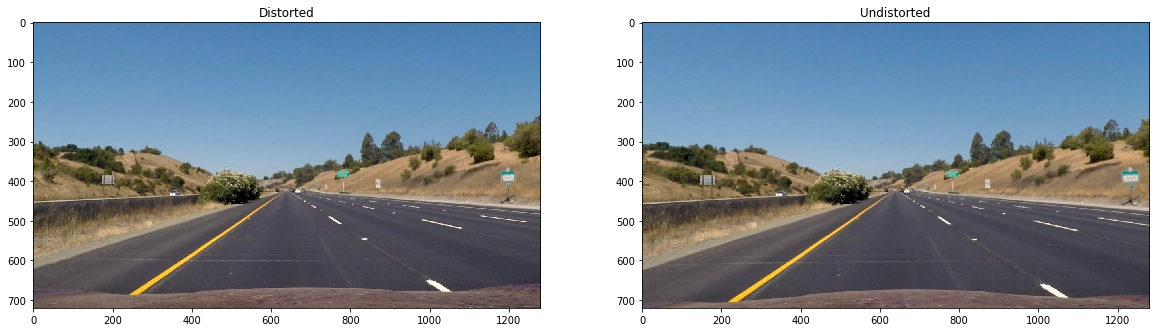

In [5]:
undist = Undistort(nx=9, ny=6)
undist.calibrate(cal_img_pth='camera_cal')
undist.show_undistorted(img_pth='test_images/straight_lines1.jpg')

***
# BINARIZE

Main steps here:
1. Color thresholing
2. Gradient thresholing (direction gradient, magnitude gradient, [Sobel](https://medium.com/datadriveninvestor/understanding-edge-detection-sobel-operator-2aada303b900))
> - Read on [Sobel vs Laplacian](http://www.aishack.in/tutorials/sobel-laplacian-edge-detectors/)
3. Combine both, and get a binary image.
4. We apply histogram equalization to improve the contrast of images.
5. Apply a light morphology to "fill the gaps" in the binary image.

## Color thresholding

- HLS
- HSV

## Gradient thresholding

- Canny edge detection, detects so many edges other than the lane lines.
- Sobel operator works on both `x` and `y` axis separately.
- Here is the $S_x$:

|-1|0 |1 |
|--|--|--|
|-2|0 |2 |
|-1|0 |1 |

- and $S_y$ is:

|1 |2 |1 |
|--|--|--|
|0 |0 |0 |
|-1|-2|-1|

- And the gradient magnitude is: $S = \sqrt{{S_x}^2 + {S_y}^2}$

- **NOTE1:** Sobel operator is a grayscale operator, so, images need to be converted into grayscale first.
- **NOTE2:** Sobel tends to identify non-edges. In order to reduce this error, it's better to apply Gaussian blurring before applying Sobel.

In [6]:
class Thresholding:
    
    def __init__(self, hsv_param, hls_param, sobel_param, filters_lst):
        self.hsv_param = hsv_param  #[min, max]
        self.hls_param = hls_param  #[min, max]
        self.sobel_param = sobel_param  #[kernel, threshold, max_val]
        self.filters_lst = filters_lst
    
    def hsv_thresh(self, img, plot=False):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsv_min = np.all(hsv > self.hsv_param[0], axis=2)
        hsv_max = np.all(hsv < self.hsv_param[1], axis=2)
        hsv_th = np.logical_and(hsv_min, hsv_max)
        if plot:
            plt.imshow(hsv_th, cmap='gray')
        return hsv_th
    
    def hls_thresh(self, img, plot=False):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        hls_min = np.all(hls > self.hls_param[0], axis=2)
        hls_max = np.all(hls < self.hls_param[1], axis=2)
        hls_th = np.logical_and(hls_min, hls_max) 
        if plot:
            plt.imshow(hls_th, cmap='gray')
        return hls_th
    
    def sobel(self, img, plot=False):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_param[0])
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_param[0])
        sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
        sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag)*255)
        _, sobel_mag = cv2.threshold(sobel_mag, 
                                     sobel_param[1], 
                                     sobel_param[2], 
                                     cv2.THRESH_BINARY)
        if plot:
            plt.imshow(sobel_mag, cmap='gray')
        return sobel_mag
    
    def plot_comparison(self, img1, img2):
        fig, ax = plt.subplots(1, 2, figsize=(20,15))
        ax[0].imshow(img1)
        ax[1].imshow(img2)
        plt.show()
    
    def combine_thresholds(self, img, plot=False):
        h, w = img.shape[:2]
        binary = np.zeros((h, w))
        if 'hsv' in self.filters_lst:
            hsv_th = self.hsv_thresh(img)
            binary = np.logical_or(binary, hsv_th)
        if 'hls' in self.filters_lst:
            hls_th = self.hls_thresh(img)
            binary = np.logical_or(binary, hls_th)
        if 'hist_eq' in self.filters_lst:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            eq_global = cv2.equalizeHist(gray)
            _, hist_eq = cv2.threshold(eq_global, 
                                       thresh=250, 
                                       maxval=255, 
                                       type=cv2.THRESH_BINARY)
            binary = np.logical_or(binary, hist_eq)
        if 'sobel' in self.filters_lst:
            sobel_th = self.sobel(img)
            binary = np.logical_or(binary, sobel_th)
        if 'morph' in self.filters_lst:
            kernel = np.ones((5, 5), np.uint8)*1
            binary = cv2.morphologyEx(binary.astype(np.uint8), 
                                      cv2.MORPH_CLOSE, kernel)
        if plot:
            plt.figure(figsize=(15,5))
            plt.imshow(binary, cmap='gray') 
        return binary

In [7]:
hls_min_thres = np.array([0, 0, 150])
hls_max_thres = np.array([255, 255, 255])
hsv_min_thres = np.array([0, 70, 70])
hsv_max_thres = np.array([50, 255, 255])
hls_param = [hls_min_thres, hls_max_thres]
hsv_param = [hsv_min_thres, hsv_max_thres]
sobel_kernel_size = 9
sobel_threshold = 50
sobel_max_val = 1
sobel_param = [sobel_kernel_size, 
               sobel_threshold, 
               sobel_max_val]
filters = ['hls', 'sobel', 'hist_eq', 'morph']
thresh = Thresholding(hls_param, hsv_param, sobel_param, filters)

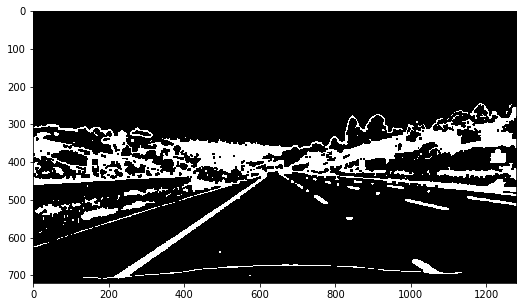

In [9]:
undist = Undistort(nx=9, ny=6)
undist.calibrate(cal_img_pth='camera_cal')
img = undist.undistort(img_pth='test_images/straight_lines1.jpg')
binary = thresh.combine_thresholds(img, plot=True)

***
# Perspective Transform

For perspective transformation, you need a 3x3 transformation matrix. Straight lines will remain straight even after the transformation. To find this transformation matrix, you need 4 points on the input image and corresponding points on the output image. Among these 4 points, 3 of them should not be collinear. Then transformation matrix can be found by the function `cv2.getPerspectiveTransform`. Then, using `cv2.warpPerspective`, we can perform the transform.

Check out the example below (from OpenCV website):

```python

img = cv2.imread('sudokusmall.png')
rows,cols,ch = img.shape

pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(img,M,(300,300))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()
```

![](myimg/perspective.jpg)

In [10]:
class PerspectiveTransform:
    
    def __init__(self, img=None, img_pth=None, src=None, dst=None):
        if img is None:
            self.img = cv2.imread(img_pth)
        else:
            self.img = img
        h, w = self.img.shape[:2]
        self.h, self.w = h, w
        if src is None:
            self._src = np.float32([[w, h-10],    # br
                                    [0, h-10],    # bl
                                    [546, 460],   # tl
                                    [732, 460]])  # tr
        else:
            self._src = src
        if dst is None:
            self._dst = np.float32([[w, h],       # br
                                    [0, h],       # bl
                                    [0, 0],       # tl
                                    [w, 0]])      # tr
        else:
            self._dst = dst
    
    @property
    def src_dst(self):
        return self._src, self._dst
    
    @src_dst.setter
    def src_dst(self, src, dst):
        self._src = src
        self._dst = dst
    
    def transform(self):
        M = cv2.getPerspectiveTransform(self._src, self._dst)
        Minv = cv2.getPerspectiveTransform(self._dst, self._src)
        return cv2.warpPerspective(self.img, M, (self.w, self.h), flags=cv2.INTER_LINEAR)

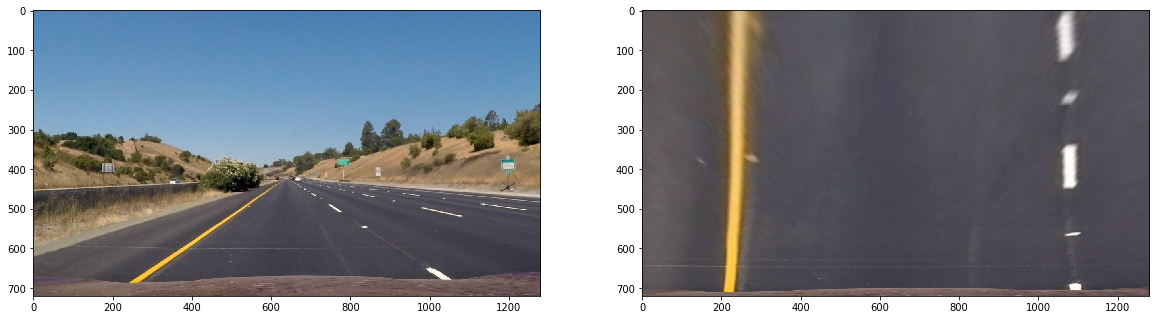

In [11]:
img_pth = 'test_images/straight_lines1.jpg'
img = cv2.imread(img_pth)
img_pt = PerspectiveTransform(img_pth=img_pth).transform()

fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_pt, cv2.COLOR_BGR2RGB))
plt.show()

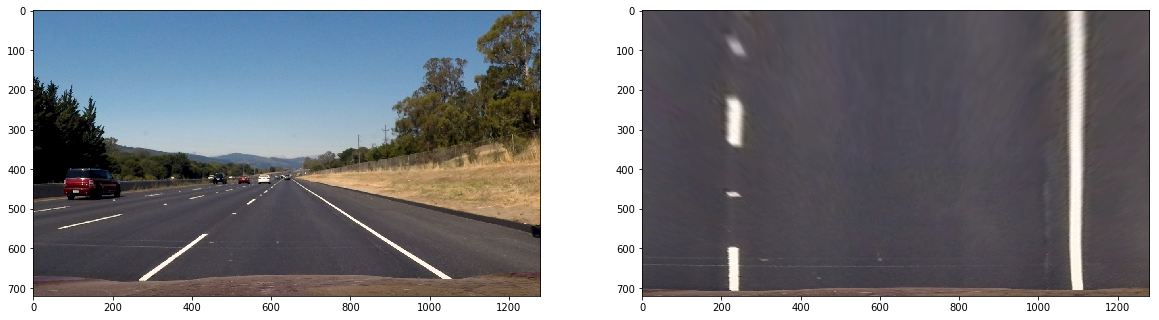

In [12]:
img_pth = 'test_images/straight_lines2.jpg'
img = cv2.imread(img_pth)
img_pt = PerspectiveTransform(img_pth=img_pth).transform()

fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_pt, cv2.COLOR_BGR2RGB))
plt.show()

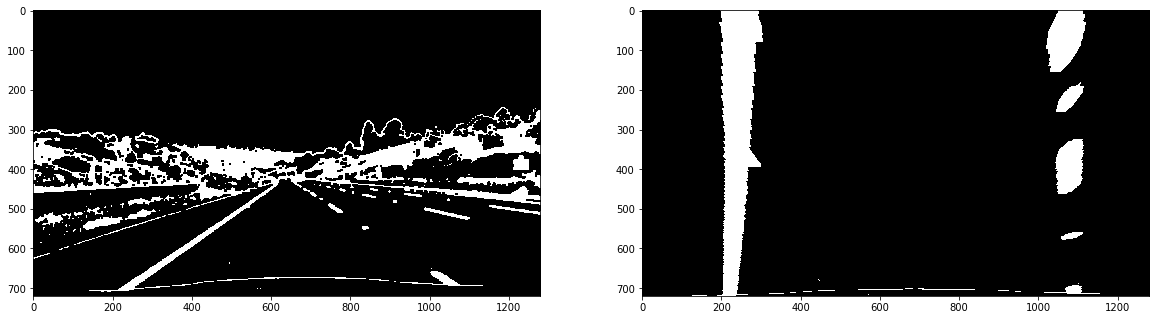

In [13]:
img_pt = PerspectiveTransform(img=binary).transform()

fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].imshow(binary, cmap='gray')
ax[1].imshow(img_pt, cmap='gray')
plt.show()

***
# Measuring Curvature

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line. Plotting a histogram of where the binary activations occur across the image is one potential solution for this.

## Sliding window
With the histogram we are adding up the pixel values along each column in the image. In the thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in the histogram will be good indicators of the x-position of the base of the lane lines. We can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame (see the image below). ![](myimg/sliding_window.png)


[Here](https://www.youtube.com/watch?time_continue=24&v=siAMDK8C_x8) is a visualization of the idea.

### STEPS

1. Split the histogram for the two lines
2. Set up windows and window hyperparameters
3. Iterate through `nwindows` to track curvature
4. Fit a polynomial
5. Visualization _(optional)_

**1.Split the histogram for the two lines**

First step is to split the histogram into two sides, one for each lane line.

```python

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
```

**2.Set up windows and window hyperparameters**

Next step is to set a few hyperparameters related to our sliding windows.

```python

# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
```

**3.Iterate through `nwindows` to track curvature**

Now, we'll want to loop for nwindows, with the given window sliding left or right if it finds the mean position of activated pixels within the window to have shifted. Here are the steps:

1. Loop through each window in `nwindows`
- Find the boundaries of our current window. This is based on a combination of the current window's starting point (`leftx_current` and `rightx_current`), as well as the `margin` you set in the hyperparameters.
- Use `cv2.rectangle` to draw these window boundaries onto our visualization image `out_img`. _(optional)_
- Now that we know the boundaries of our window, find out which activated pixels from `nonzeroy` and `nonzerox` above actually fall into the window.
- Append these to our lists `left_lane_inds` and `right_lane_inds`.
- If the number of pixels you found in Step 4 are greater than your hyperparameter `minpix`, re-center our window (i.e. `leftx_current` or `rightx_current`) based on the mean position of these pixels.

Find the codes [here](https://github.com/alibakh62/Udacity_SDC_ND/blob/master/notes/scripts/find_lanes_sliding_window.py)

**4.Fit a polynomial**

Now that we have found all our pixels belonging to each line through the sliding window method, we fit a polynomial to the line. First, we need to take few steps to get the data ready for fitting.

```python

# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Assuming we have `left_fit` and `right_fit` from `np.polyfit` before
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
```

**5.Visualization**

One way of doing it:

```python

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
```

## Finding the Lines: Window Convolution

Refer to [this code](https://github.com/alibakh62/Udacity_SDC_ND/blob/master/notes/scripts/find_lanes_sliding_window_convolution.py) for an implementation.


## Finding the Lines: Search from Prior

Now we've built an algorithm that uses sliding windows to track the lane lines out into the distance. However, using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.

![](myimg/search_from_prior.png)

In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous lane line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame.

This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.

In sliding window, we used `left_lane_inds` and `right_lane_inds` to hold the pixel values contained within the boundaries of a given sliding window. This time, we'll take the polynomial functions we fit before (`left_fit` and `right_fit`), along with a hyperparameter `margin`, to determine which activated pixels fall into the green shaded areas from the above image. Note that this `margin` can be a different value than the one originally used for your sliding windows!

Refer to [this file](https://github.com/alibakh62/Udacity_SDC_ND/blob/master/notes/scripts/find_lanes_search_from_prior.py) for an implementation of search from prior.



## Sliding Window

In [22]:
class SlidingWindow:
    """
    accepts binary warped image
    returns sliding window
    """
    
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
    
    def find_lane_pixels(self, binary_warped):

        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # ---------------
        # number of sliding windows
        nwindows = 9
        # width of the windows +/- margin
        margin = 100
        # minimum number of pixels found to recenter window
        minpix = 50

        # height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window 
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # Recenter next window if you found > minpix pixels
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            pass

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img


    def fit_polynomial(self, binary_warped):
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)

        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
            right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        except TypeError:
            
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        return out_img

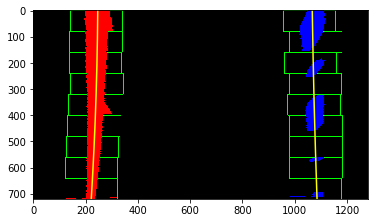

In [23]:
sw = SlidingWindow()
out_img = sw.fit_polynomial(img_pt)
plt.imshow(out_img)

## Search From prior

In [26]:
class SearchFromPrior:
    
    def __init__(self, left_fit, right_fit):
        self.left_fit = left_fit
        self.right_fit = right_fit
        
    def _fit_poly(self, img_shape, leftx, lefty, rightx, righty):
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        return left_fitx, right_fitx, ploty

    def search_around_poly(self, binary_warped):
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # finding search area based on polynomial fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        left_fitx, right_fitx, ploty = self._fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        return result

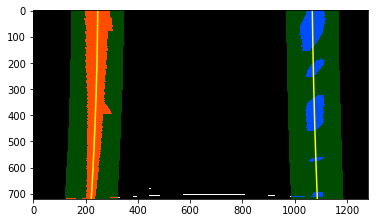

In [27]:
left_fit, right_fit = sw.left_fit, sw.right_fit
sfp = SearchFromPrior(left_fit, right_fit)
out_img = sfp.search_around_poly(img_pt)
plt.imshow(out_img)